In [24]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.mixture import GaussianMixture

import numpy as np
SEED = 42

In [15]:
aerolinea_df = pd.read_excel("/content/EastWestAirlines.xlsx", engine="openpyxl", sheet_name="data")
aerolinea_df=pd.DataFrame(aerolinea_df)
aerolinea_df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [16]:
#Revisar que no tengan datos nulos los campos de la aérolinea

aerolinea_df.isnull().sum()

,0
ID#,0
Balance,0
Qual_miles,0
cc1_miles,0
cc2_miles,0
cc3_miles,0
Bonus_miles,0
Bonus_trans,0
Flight_miles_12mo,0
Flight_trans_12,0


In [17]:
aerolinea_df.describe()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [18]:
#Eliminar columna ID
aerolinea_df = aerolinea_df.drop(columns="ID#")
#Dejar para manipular más facil los datos dejar las columna en minuscula
aerolinea_df.columns = aerolinea_df.columns.str.lower()
#Renombrar columna award para que no quede con el simbolo de pregunta
aerolinea_df.rename(columns={"award?": "award"}, inplace=True)
aerolinea_df.head()

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12,days_since_enroll,award
0,28143,0,1,1,1,174,1,0,0,7000,0
1,19244,0,1,1,1,215,2,0,0,6968,0
2,41354,0,1,1,1,4123,4,0,0,7034,0
3,14776,0,1,1,1,500,1,0,0,6952,0
4,97752,0,4,1,1,43300,26,2077,4,6935,1


In [19]:
# Se escalan los Datos
scaler = MinMaxScaler()
aerolinea_df[aerolinea_df.columns] = scaler.fit_transform(aerolinea_df[aerolinea_df.columns])
aerolinea_df.head()

,balance,qual_miles,cc1_miles,cc2_miles,cc3_miles,bonus_miles,bonus_trans,flight_miles_12mo,flight_trans_12,days_since_enroll,award
0,0.016508,0.0,0.00,0.0,0.0,0.000660,0.011628,0.000000,0.000000,0.843742,0.0
1,0.011288,0.0,0.00,0.0,0.0,0.000815,0.023256,0.000000,0.000000,0.839884,0.0
2,0.024257,0.0,0.00,0.0,0.0,0.015636,0.046512,0.000000,0.000000,0.847842,0.0
3,0.008667,0.0,0.00,0.0,0.0,0.001896,0.011628,0.000000,0.000000,0.837955,0.0
4,0.057338,0.0,0.75,0.0,0.0,0.164211,0.302326,0.067398,0.075472,0.835905,1.0


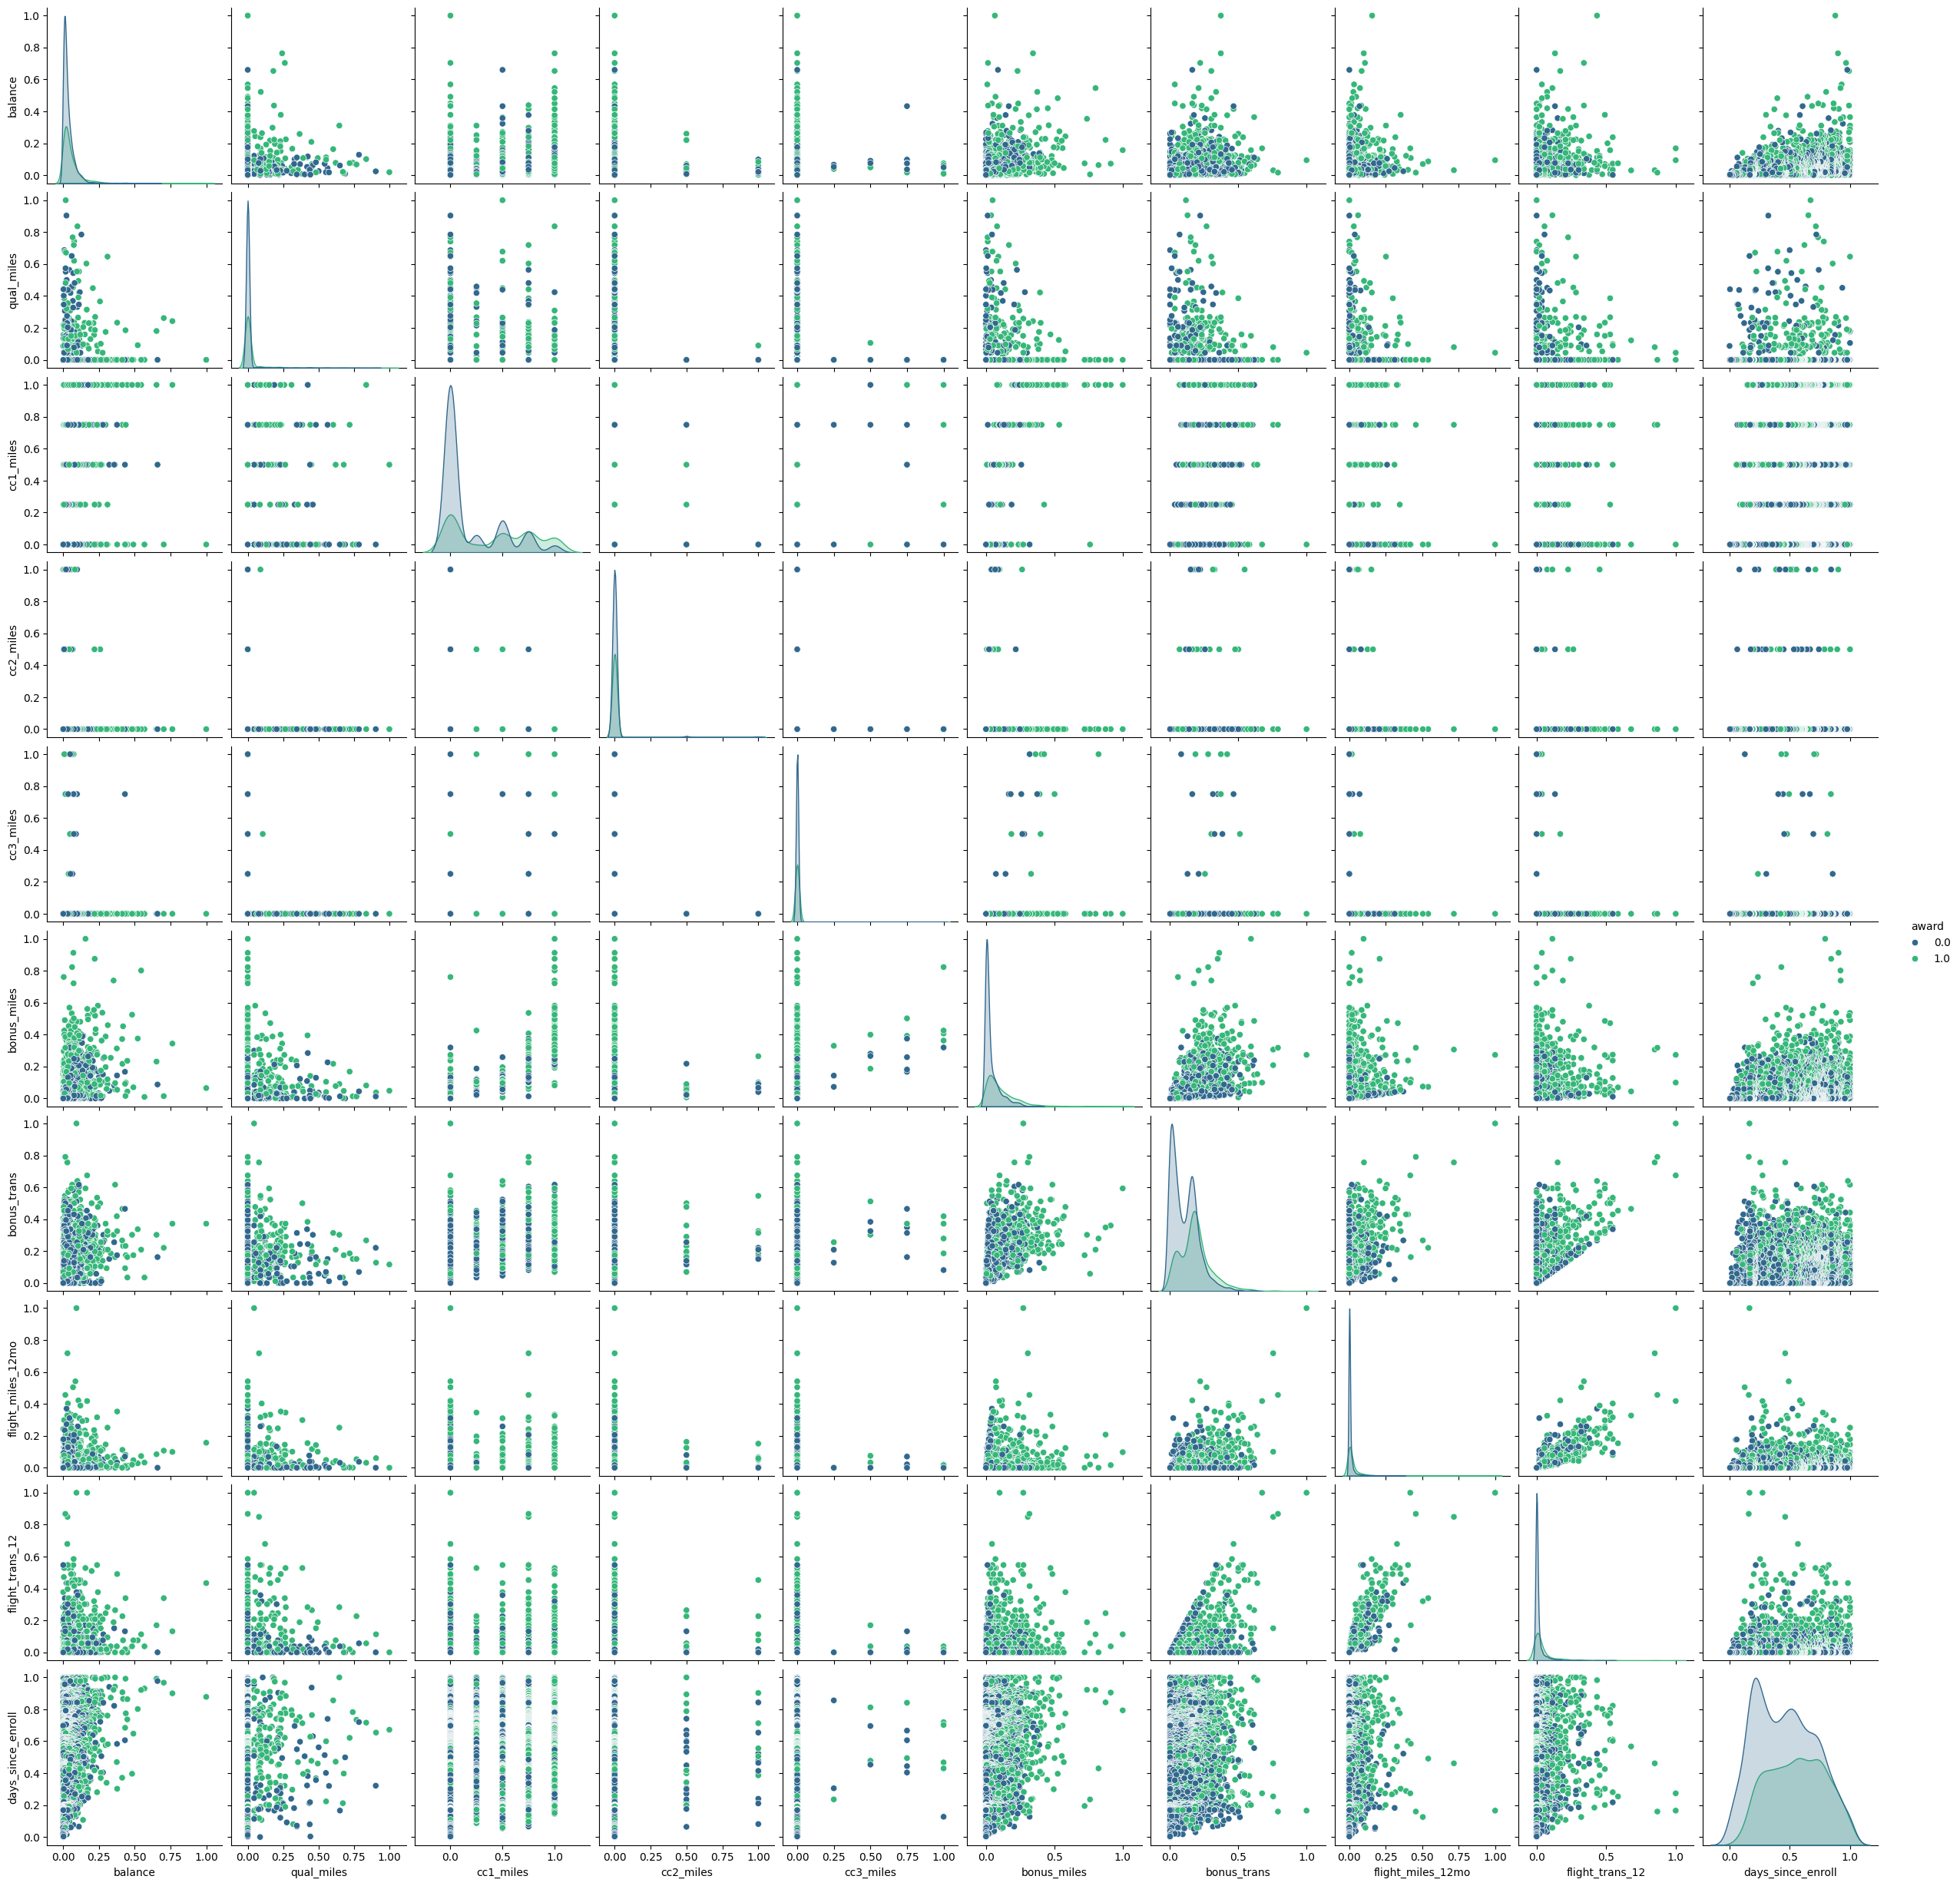

In [20]:
import seaborn as sns
sns.pairplot(aerolinea_df, hue="award", palette='viridis')

In [21]:
# Con nuestro dataset establecido y escalado procedemos a implementar el metodo del codo y
# la silueta para determinar el numero optimo de clusters

def scatter_plot(X, y=None):
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(figsize=(7, 4))

  if y is None:
    ax.scatter(X[:, 1], X[:, 9], marker=".", s=10)
  else:
    ax.scatter(X[:, 1], X[:, ], marker=".", s=10, c=y)

  ax.set_xlabel("$x_1$", fontsize=14)
  ax.set_ylabel("$x_2$", fontsize=14)
  ax.tick_params(axis='both', labelsize=8)

  ax.grid(False)
  plt.tight_layout()

  plt.savefig("scatter.png", dpi=600, transparent=True)

  plt.show()

In [22]:
def train_kmeans(X):
    ks = np.linspace(2, 8, 7, dtype=np.int64)  # Generaremos 7 clusters de 2 a 8
    inertias = []
    silhouettes = []
    davies_bouldin = []
    kmeans_k = []

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=SEED)
        kmeans.fit(X)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
        davies_bouldin.append(davies_bouldin_score(X, kmeans.labels_))
        kmeans_k.append(kmeans)

    return kmeans_k, inertias, silhouettes, davies_bouldin, ks

In [25]:
kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks = train_kmeans(aerolinea_df)

In [26]:
def print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin, ks):
    print("\nResultados de KMeans:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "Inertia", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks[i], inertias[i], silhouettes[i], davies_bouldin[i]))

print_kmeans_results(kmeans_k, inertias, silhouettes, davies_bouldin_knn, ks)


Resultados de KMeans:
 Clusters      Inertia       Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2          823.68          0.5359             0.8228       
    3          625.18          0.4646             0.8332       
    4          436.72          0.4745             0.8902       
    5          409.84          0.4362             0.9931       
    6          324.26          0.4329             0.9627       
    7          290.47          0.3926             1.0980       
    8          270.90          0.3921             1.0517       


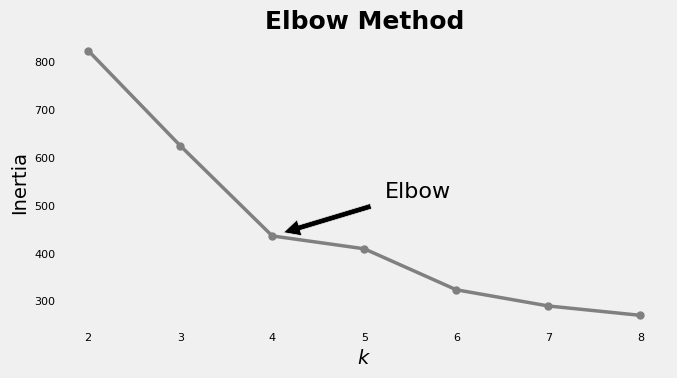

In [27]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, inertias, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Inertia", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, inertias[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow.png", dpi=600, transparent=True)
plt.show()

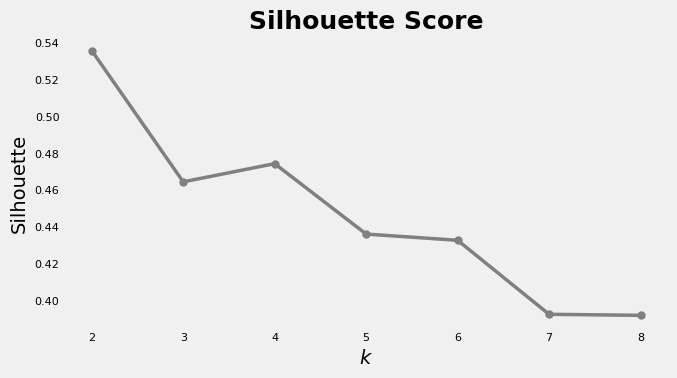

In [28]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)



plt.tight_layout()
plt.savefig("silhouette_score.png", dpi=600, transparent=True)
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.4646127065079619
For n_clusters = 4 The average silhouette_score is : 0.4744941579482721
For n_clusters = 5 The average silhouette_score is : 0.43623735714822565
For n_clusters = 6 The average silhouette_score is : 0.43285287948445184


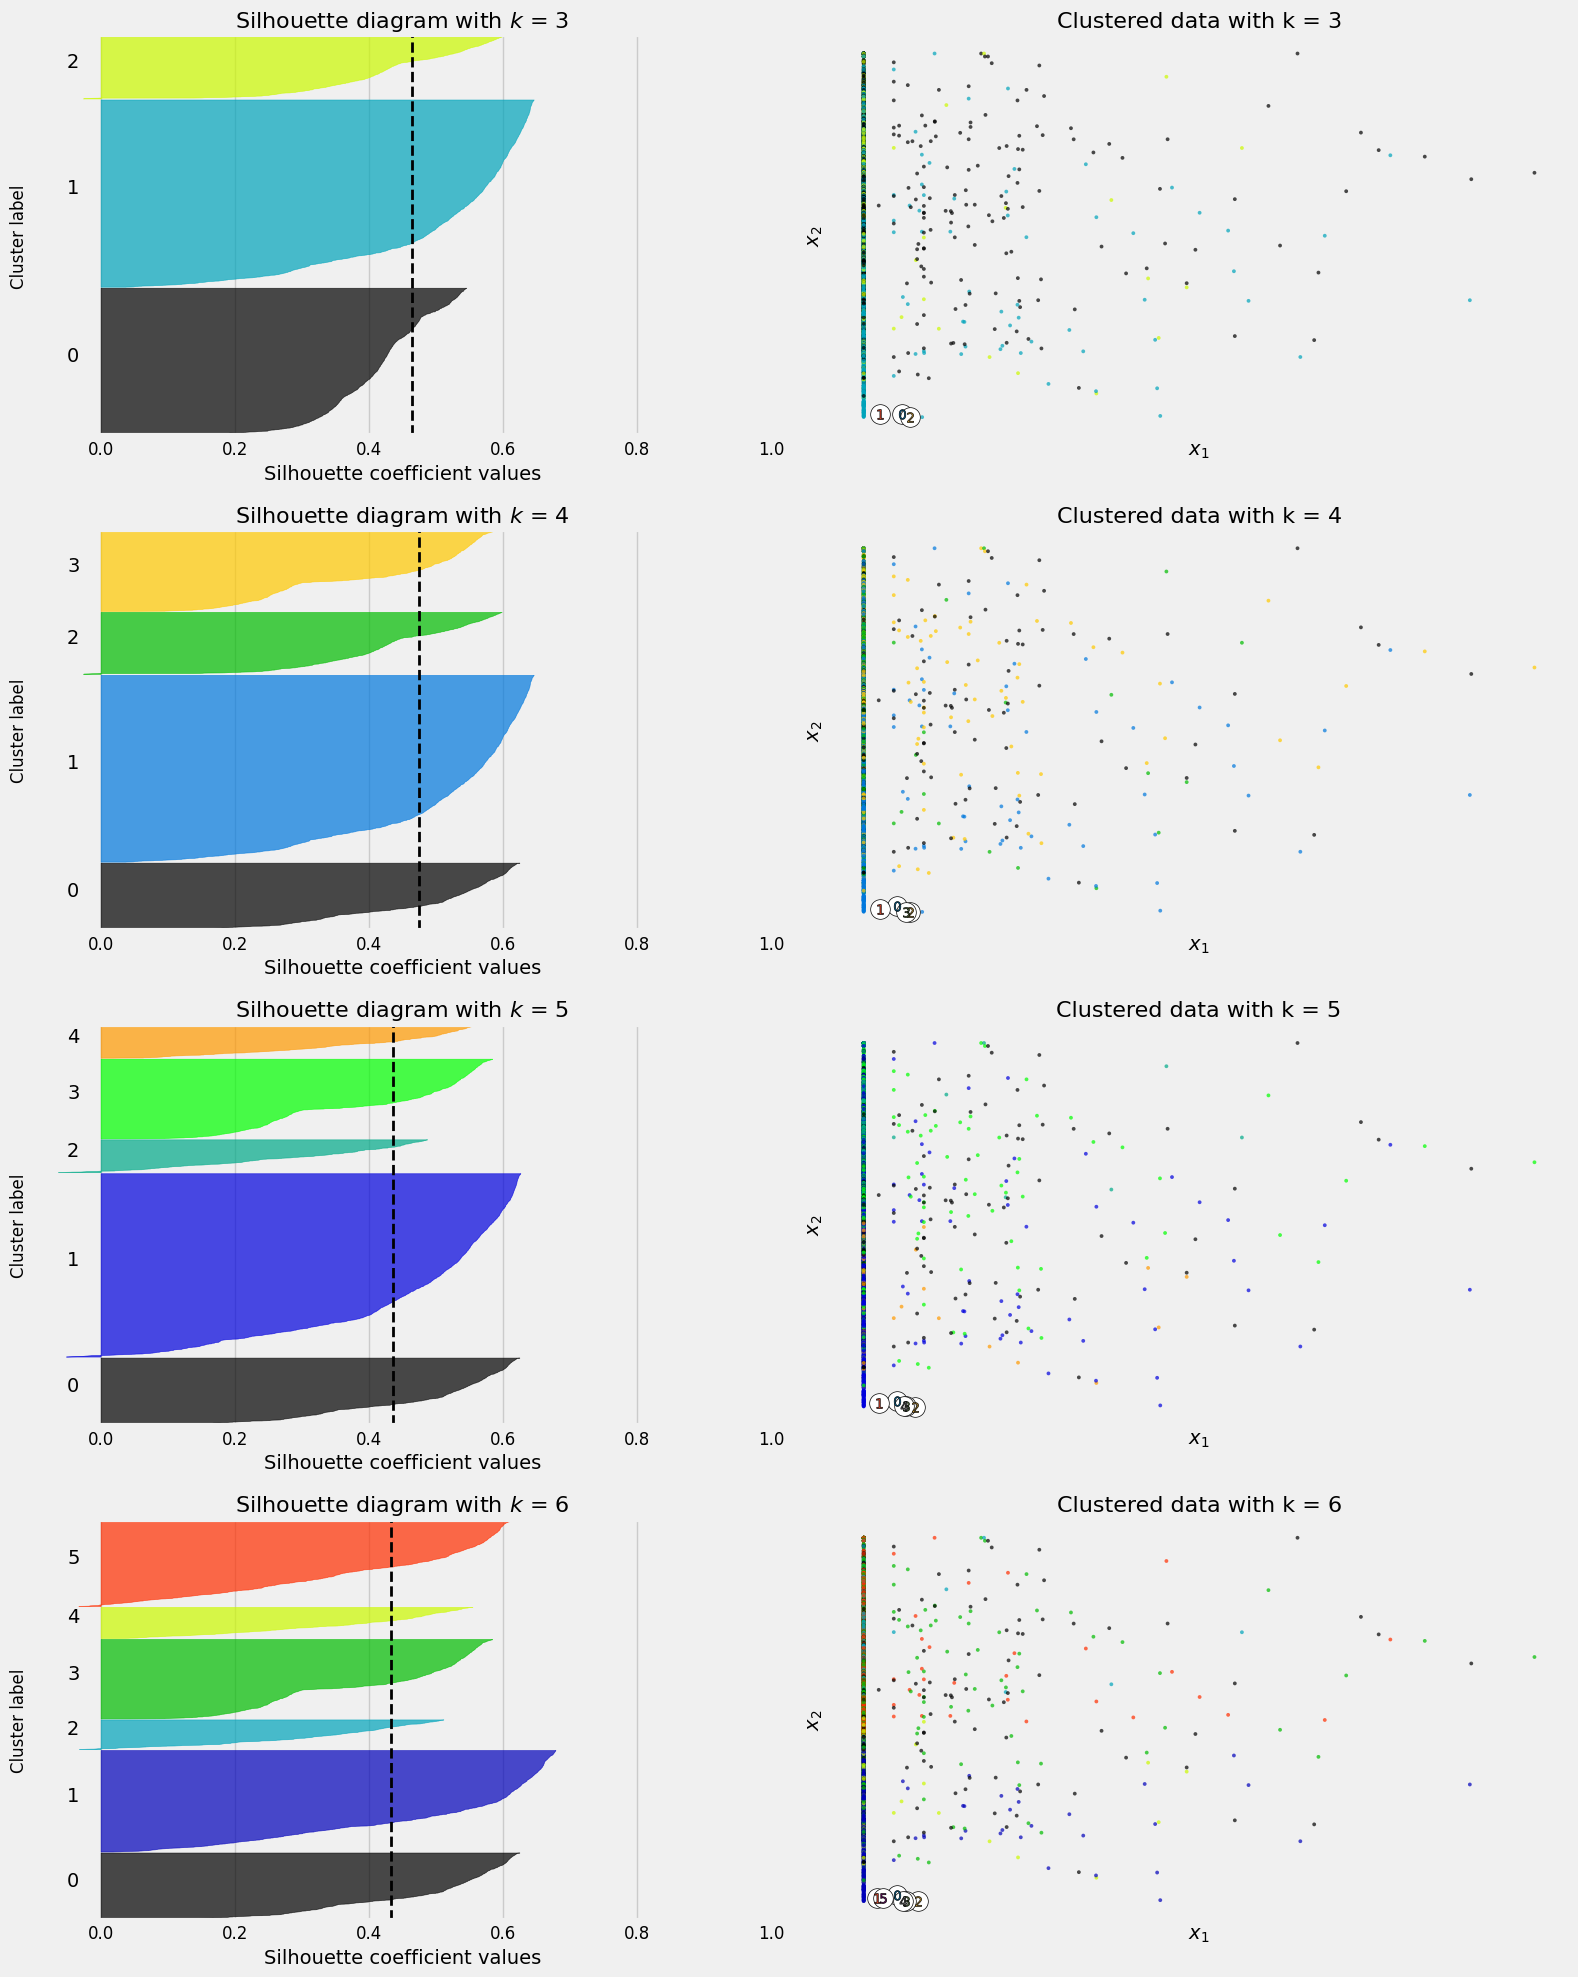

In [30]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))



for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(aerolinea_df) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = kmeans_k[n_clusters-2].predict(aerolinea_df)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(aerolinea_df, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(aerolinea_df, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(aerolinea_df.iloc[:, 1], aerolinea_df.iloc[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = kmeans_k[n_clusters-2].cluster_centers_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram.png", dpi=650, transparent=False)
plt.show()

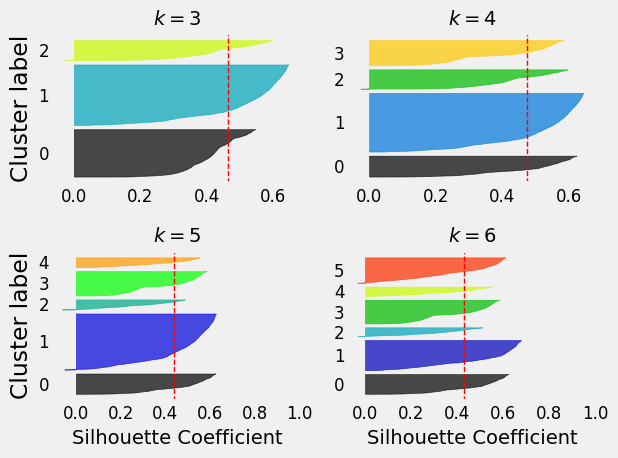

In [32]:

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(aerolinea_df, y_pred)

    padding = len(aerolinea_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


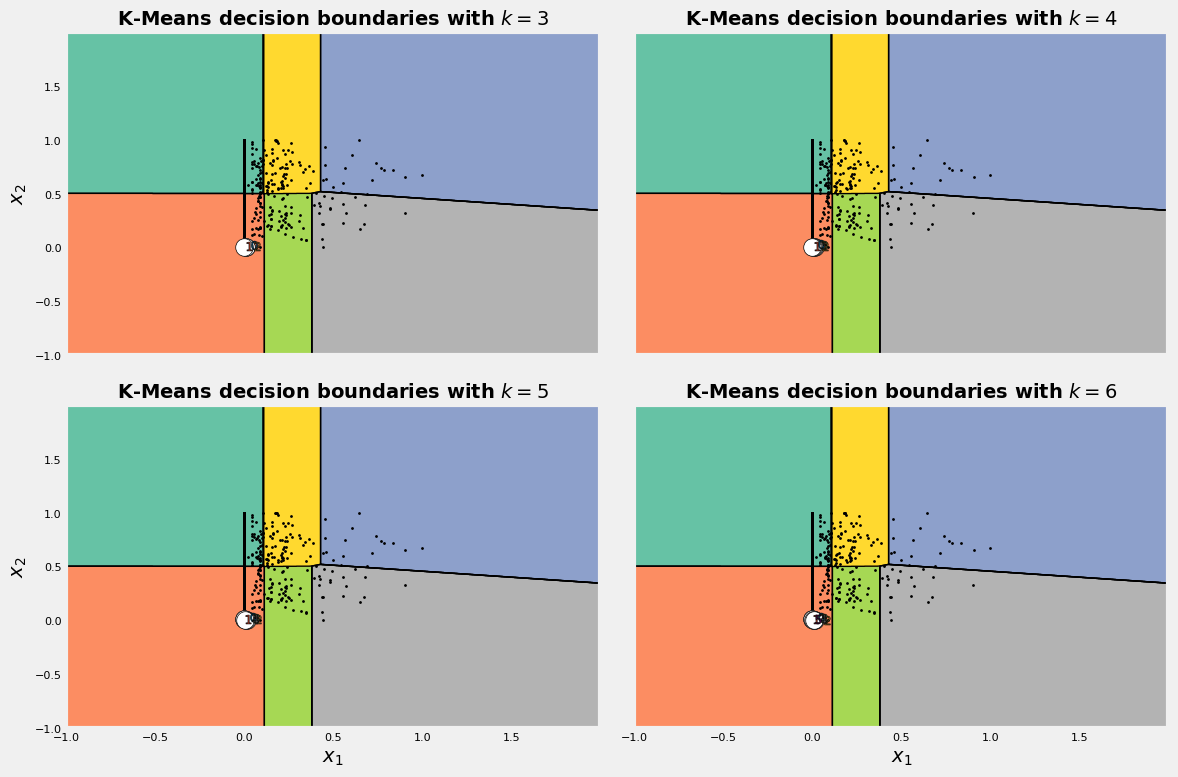

In [33]:
# Seleccionamos dos features relevantes
X_2d = aerolinea_df[['qual_miles', 'award']]
# Entrenar KMeans en este subconjunto
kmeans_2d = KMeans(n_clusters=k, random_state=SEED)
kmeans_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = aerolinea_df.iloc[:, 1].min() - 1, aerolinea_df.iloc[:, 9].max() + 1
y_min, y_max = aerolinea_df.iloc[:, 1].min() - 1, aerolinea_df.iloc[:, 9].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(aerolinea_df.iloc[:, 1], aerolinea_df.iloc[:, 9], 'k.', markersize=2)

  centers = kmeans_k[k-2].cluster_centers_
  ax[i, j].scatter(centers[:, 3], centers[:, 4], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("K-Means decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries.png", dpi=800, transparent=True)
plt.show()

GMM

In [34]:
def train_gmm(X):
    ks_gmm = np.linspace(2, 8, 7, dtype=np.int64)  # Generamos 7 modelos GMM con k de 2 a 8
    bics = []
    silhouettes = []
    davies_bouldin = []
    gmm_models = []

    for k in ks_gmm:
        gmm = GaussianMixture(n_components=k, random_state=SEED)
        gmm.fit(X)

        # Se calcula el BIC; mientras menor sea, mejor se ajusta el modelo
        bic_val = gmm.bic(X)
        bics.append(bic_val)

        # Se obtienen las etiquetas para cada punto y se calcula el coeficiente de silueta
        labels = gmm.predict(X)
        silhouette_val = silhouette_score(X, labels)
        silhouettes.append(silhouette_val)

        # Se calcula Davies-Bouldin Index
        dbi_val = davies_bouldin_score(X, labels)
        davies_bouldin.append(dbi_val)

        gmm_models.append(gmm)

    return gmm_models, bics, silhouettes, davies_bouldin, ks_gmm

In [35]:
 gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm = train_gmm(aerolinea_df)

In [36]:
def print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin, ks_gmm):
    print("\nResultados de GMM:")
    print("{:^10} {:^15} {:^15} {:^20}".format("Clusters", "BIC", "Silhouette", "Davies-Bouldin Index"))
    print("-" * 60)
    for i in range(len(ks_gmm)):
        print("{:^10} {:^15.2f} {:^15.4f} {:^20.4f}".format(ks_gmm[i], bics[i], silhouettes[i], davies_bouldin[i]))

print_gmm_results(gmm_models, bics, silhouettes, davies_bouldin_gmm, ks_gmm)


Resultados de GMM:
 Clusters        BIC         Silhouette    Davies-Bouldin Index
------------------------------------------------------------
    2        -143120.25        0.5359             0.8228       
    3        -175149.97        0.3538             1.1969       
    4        -213259.28        0.2670             2.9672       
    5        -234573.30        0.1345             4.0225       
    6        -253985.48        0.2129             3.1090       
    7        -268254.44        0.1839             2.3480       
    8        -270687.79        0.1981             2.7412       


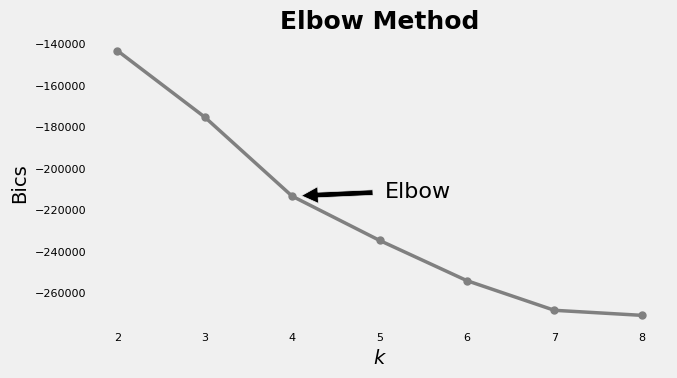

In [37]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, bics, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Bics", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Elbow Method", fontsize=18, fontweight="bold")
ax.grid(False)

ax.annotate("Elbow",
            xy=(4, bics[2]),
            xytext=(0.55, 0.45),
            textcoords="figure fraction",
            fontsize=16,
            arrowprops=dict(facecolor="black", shrink=0.1)
            )

plt.tight_layout()
plt.savefig("elbow.png", dpi=600, transparent=True)
plt.show()

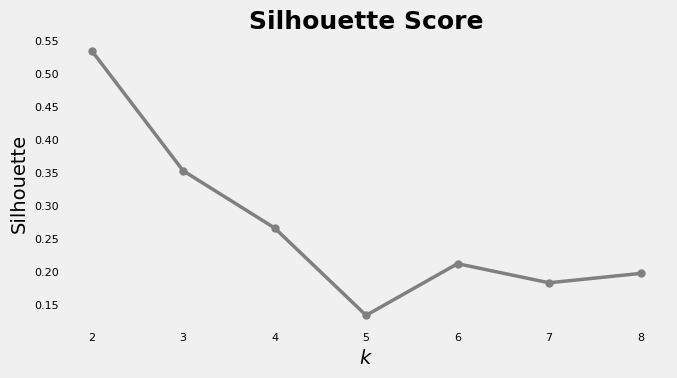

In [38]:
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(ks_gmm, silhouettes, "o-", color="grey", linewidth=2.5, markersize=5)

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette", fontsize=14)
ax.tick_params(axis='both', labelsize=8)

ax.set_title("Silhouette Score", fontsize=18, fontweight="bold")
ax.grid(False)

# ax.annotate("silhouette score = {:.2f}".format(silhouettes[3]),
#             xy=(5, silhouettes[3]),
#             xytext=(0.65, 0.8),
#             textcoords="figure fraction",
#             fontsize=12,
#             arrowprops=dict(facecolor="black", shrink=0.1)
#             )

plt.tight_layout()
plt.savefig("silhouette_score.png", dpi=600, transparent=True)
plt.show()

For n_clusters = 3 The average silhouette_score is : 0.3537612909718156
For n_clusters = 4 The average silhouette_score is : 0.2669935015821507
For n_clusters = 5 The average silhouette_score is : 0.13451943716555273
For n_clusters = 6 The average silhouette_score is : 0.21285680209784968


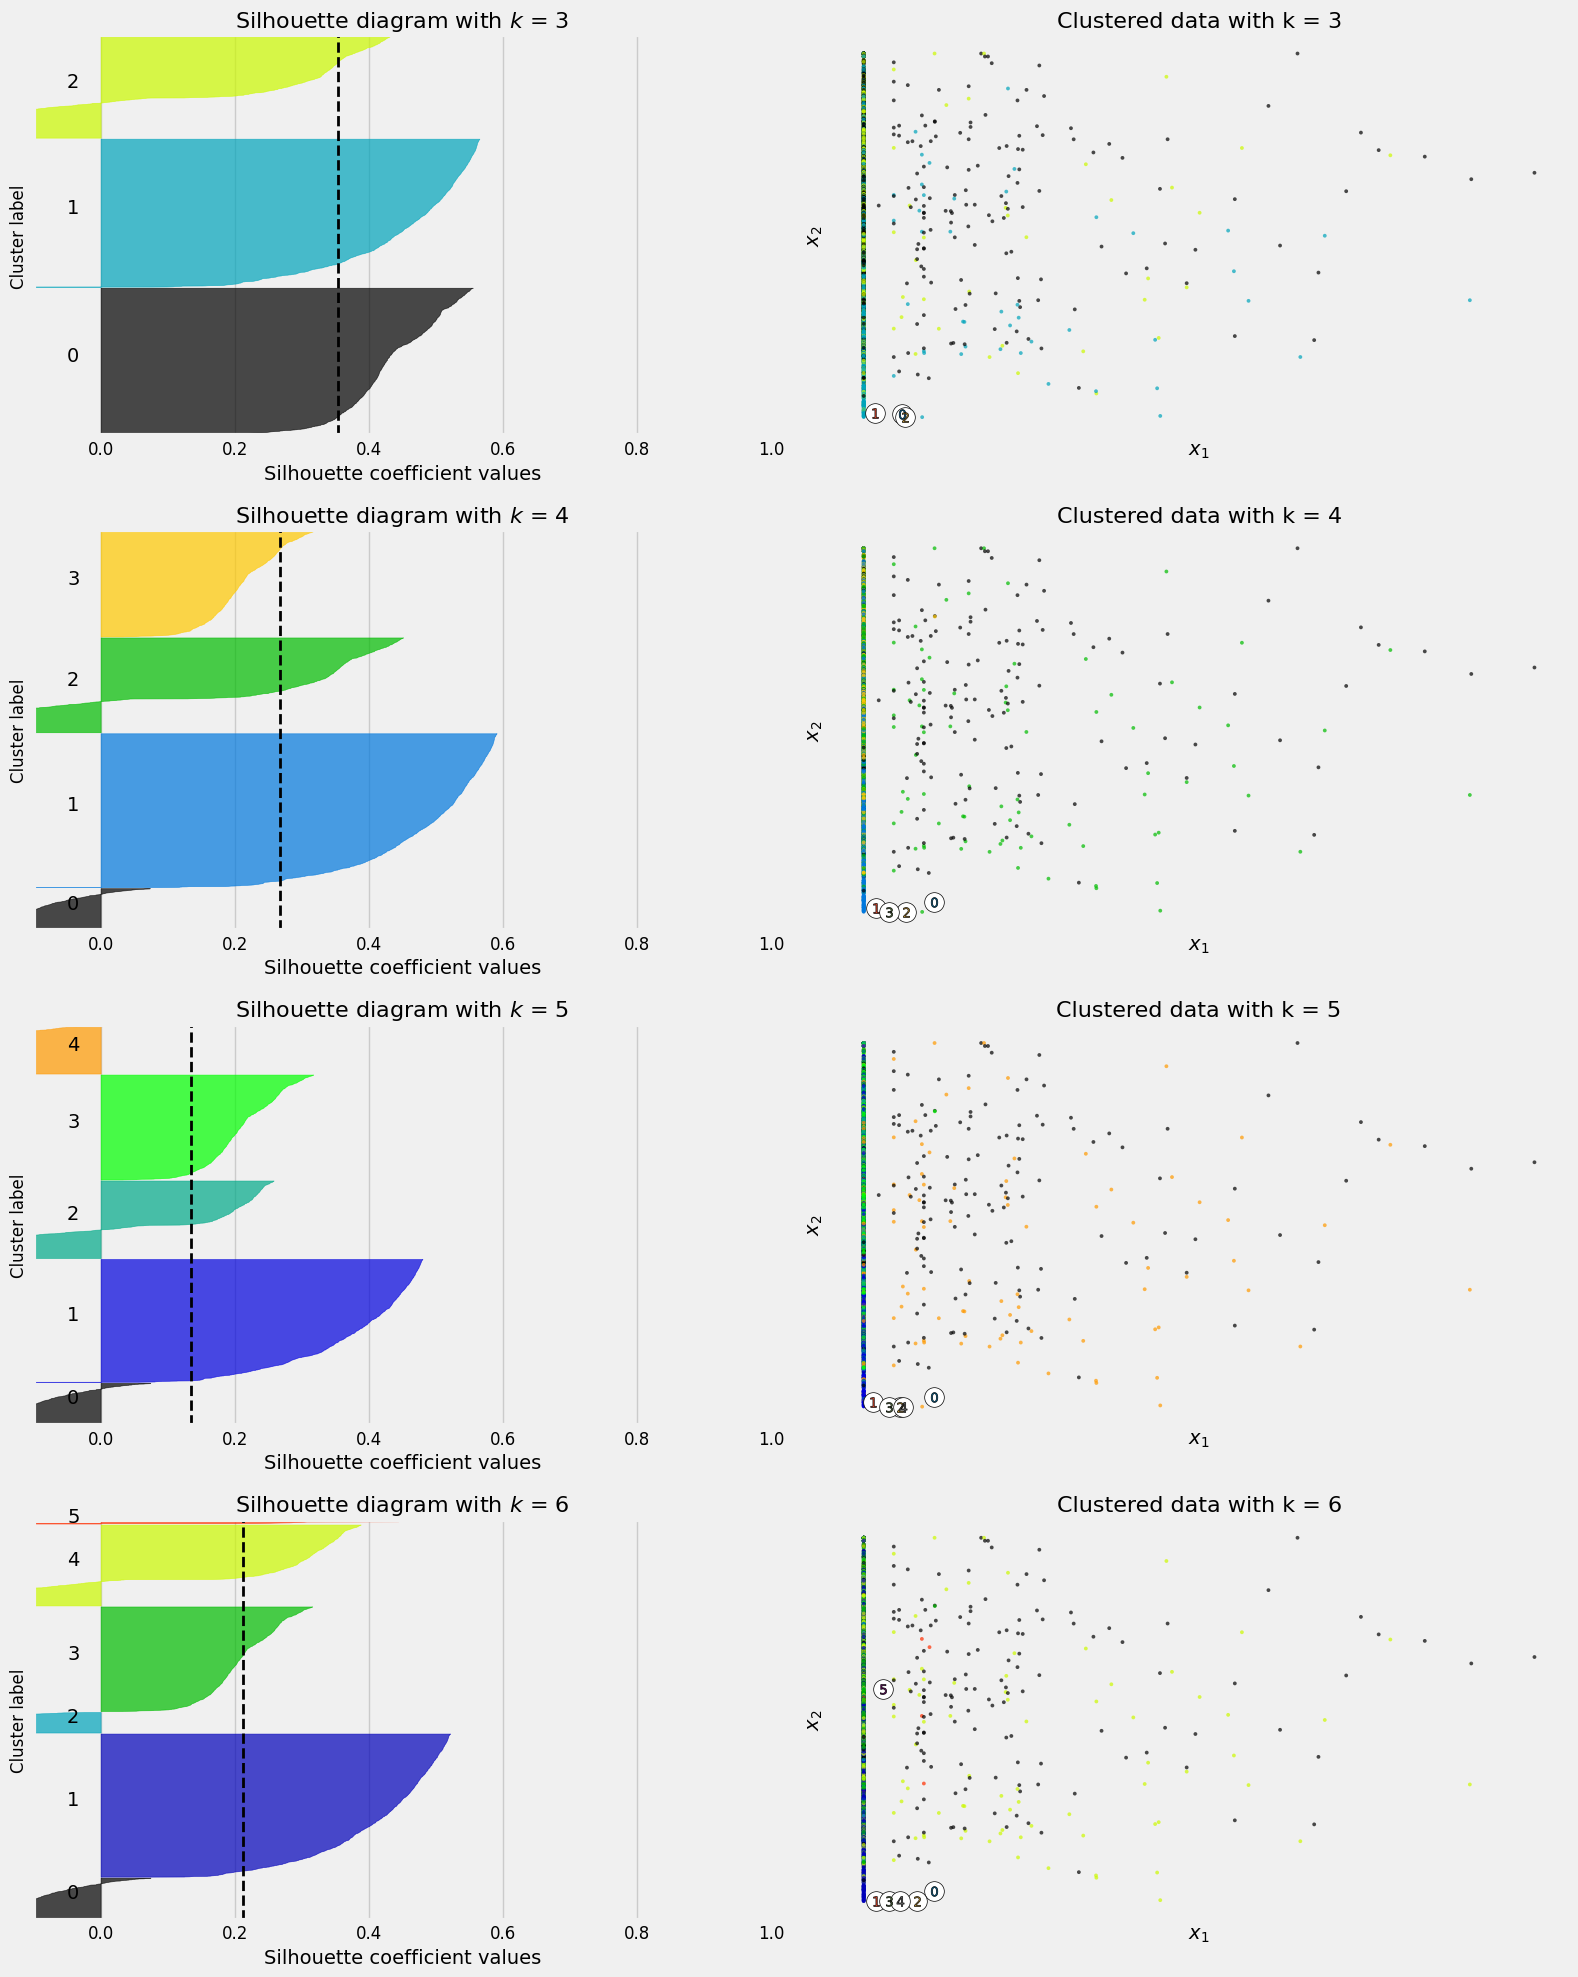

In [39]:
range_n_clusters = [3, 4, 5, 6]

fig, ax = plt.subplots(4, 2, figsize=(16, 20))

# [0, 0] [0, 1]
# [1, 0] [1, 1]
# [2, 0] [2, 1]
# [3, 0] [3, 1]

for row, n_clusters in enumerate(range_n_clusters):

  # Create a subplot with 1 row and 2 columns
  # fig, (ax1, ax2) = plt.subplots(1, 2)

  # fig.set_size_inches(12, 6)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax[row, 0].set_xlim([-0.1, 1])

  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax[row, 0].set_ylim([0, len(aerolinea_df) + (n_clusters + 1) * 10])

  # get predictions for each label
  cluster_labels = gmm_models[n_clusters-2].predict(aerolinea_df)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(aerolinea_df, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette score for each sample
  sample_silhouette_values = silhouette_samples(aerolinea_df, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax[row, 0].fill_betweenx(np.arange(y_lower, y_upper),
                           0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax[row, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax[row, 0].set_title("Silhouette diagram with $k$ = {}".format(n_clusters), fontsize=16)
  ax[row, 0].set_xlabel("Silhouette coefficient values", fontsize=14)
  ax[row, 0].set_ylabel("Cluster label", fontsize=12)

  ax[row, 0].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  ax[row, 0].tick_params(axis='both', which='major', labelsize=12)

  # The vertical line for average silhouette score of all the values
  ax[row, 0].axvline(x=silhouette_avg, color="black", linestyle="--", linewidth=2)

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax[row, 1].scatter(aerolinea_df.iloc[:, 1], aerolinea_df.iloc[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                     c=colors, edgecolor='k')

  # Labeling the clusters
  centers = gmm_models[n_clusters-2].means_
  # Draw white circles at cluster centers
  ax[row, 1].scatter(centers[:, 0], centers[:, 3], marker='o',
                     c="white", alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax[row, 1].scatter(c[0], c[3], marker='$%d$' % i, alpha=1,
                       s=50, edgecolor='k')

  ax[row, 1].set_title(f"Clustered data with k = {n_clusters}", fontsize=16)
  ax[row, 1].set_xlabel("$x_1$", fontsize=14)
  ax[row, 1].set_ylabel("$x_2$", fontsize=14)
  ax[row, 1].set_yticks([])  # Clear the yaxis labels / ticks
  ax[row, 1].set_xticks([])

  ax[row, 1].grid(False)

  # fig.suptitle(("Silhouette analysis for KMeans clustering "
  # "with $k$ = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig("silhouette_diagram.png", dpi=650, transparent=False)
plt.show()

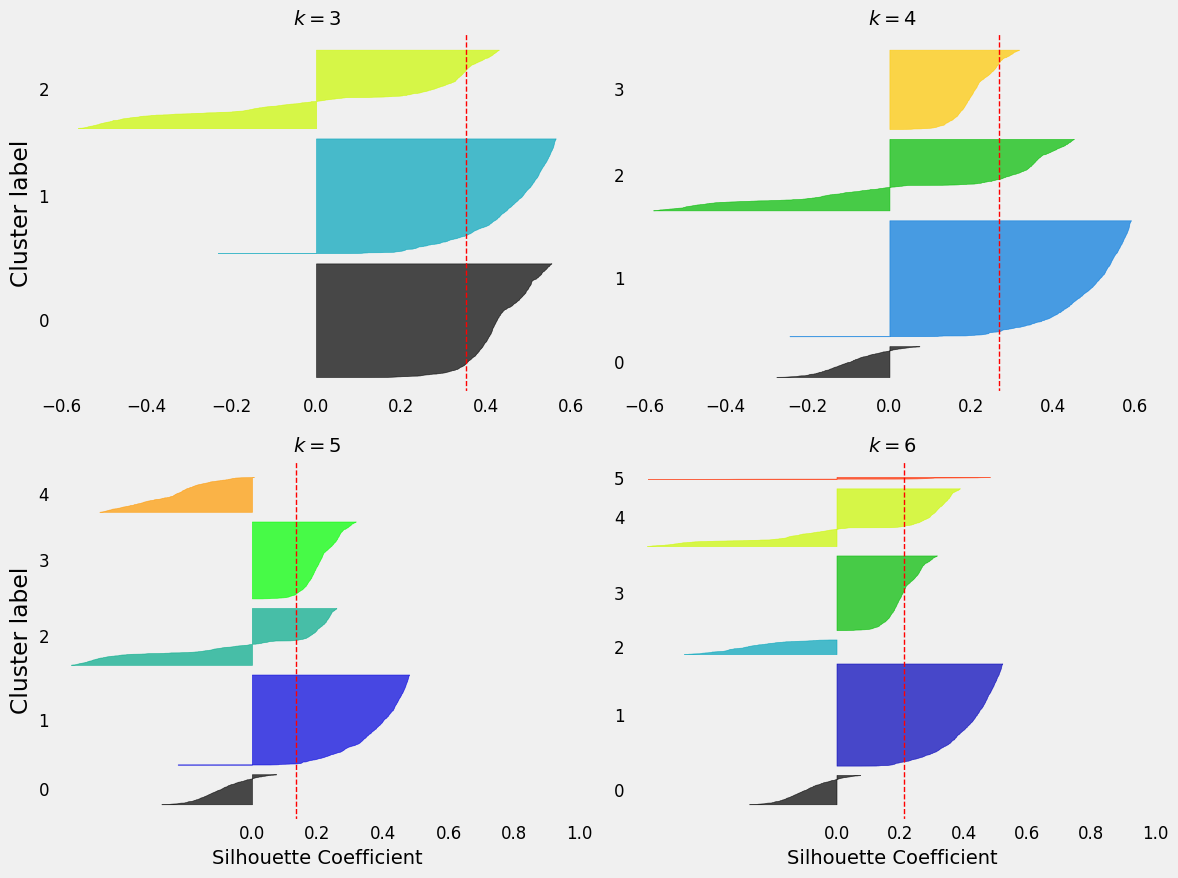

In [40]:
plt.figure(figsize=(12, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = gmm_models[k - 2].predict(aerolinea_df)
    silhouette_coefficients = silhouette_samples(aerolinea_df, y_pred)

    padding = len(aerolinea_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.nipy_spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster label")

    if k in (5, 6):
      plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
      plt.xlabel("Silhouette Coefficient", fontsize=14)
    # else:
    #     plt.tick_params(labelbottom=False)
    plt.tick_params(labelsize=12)
    plt.axvline(x=silhouettes[k - 2], color="red", linestyle="--", linewidth=1)
    plt.title("$k={}$".format(k), fontsize=14, fontweight="bold")

    plt.grid(False)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


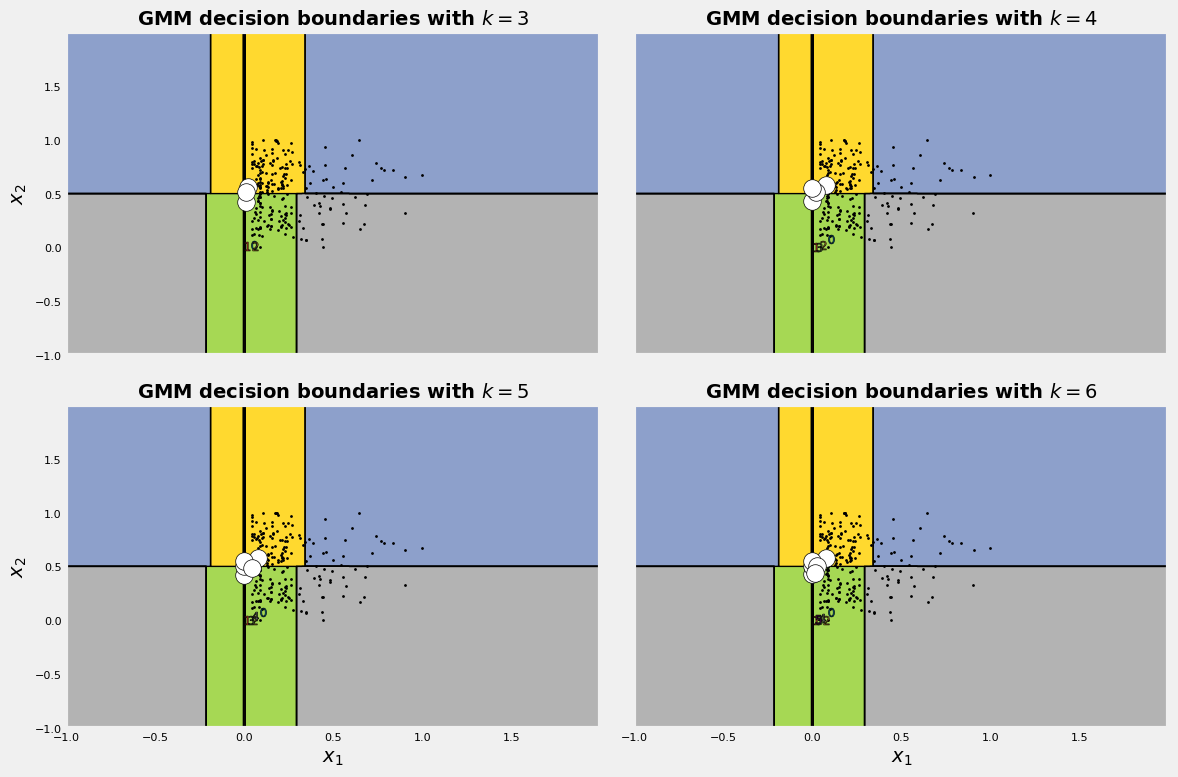

In [41]:
# Seleccionamos dos features relevantes
X_2d = aerolinea_df[['qual_miles', 'award']]
# Entrenar GMM en este subconjunto

gmm_2d = GaussianMixture(n_components=k, random_state=SEED)
gmm_2d.fit(X_2d)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .001     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = aerolinea_df.iloc[:, 1].min() - 1, aerolinea_df.iloc[:, 9].max() + 1
y_min, y_max = aerolinea_df.iloc[:, 1].min() - 1, aerolinea_df.iloc[:, 9].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# [0, 0] [0, 1]
# [1, 0] [1, 1]

for i, j, k in zip([0, 0, 1, 1], [0, 1, 0, 1], [3, 4, 5, 6]):

  # Obtain labels for each point in mesh. Use last trained model.
  Z = gmm_2d.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  ax[i, j].contourf(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Set2")
  ax[i, j].contour(Z, extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              linewidths=1, colors='k')

  ax[i, j].plot(aerolinea_df.iloc[:, 1], aerolinea_df.iloc[:, 9], 'k.', markersize=2)

  centers = gmm_models[k-2].means_
  ax[i, j].scatter(centers[:, 1], centers[:, 9], marker='o',
                  c="white", alpha=1, s=160, edgecolor='k', zorder=5)
  for cluster_idx, c in enumerate(centers):
    ax[i, j].scatter(c[0], c[1], marker='$%d$' % cluster_idx, alpha=1,
                    s=40, edgecolor='k', zorder=10)

  ax[i, j].set_title("GMM decision boundaries with $k = {}$".format(k),
                    fontsize=14, fontweight="bold")

  if k % 2 == 1:
    ax[i, j].set_ylabel("$x_2$", fontsize=14)

  if k >= 5:
    ax[i, j].set_xlabel("$x_1$", fontsize=14)

  ax[i, j].tick_params(axis='both', labelsize=8)

  ax[i, j].grid(False)

plt.tight_layout()
plt.savefig("decision_boundaries.png", dpi=800, transparent=True)
plt.show()